In [2]:
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from scipy.interpolate import interp1d
import math
import pandas as pd
import pickle as pk
import h5py
import time
from astropy import wcs
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
import astropy.table as tb 
from astropy.time import Time 
from astroquery.jplhorizons import Horizons

import re
from numba import jit


In [3]:
@jit(nopython=True)
def strange_check(strange_handles, target):
    #A small helper function that finds the index of our target plannet. Due to a difference 
    #in naming scheme we unfortunately can't just use np.where or something like that
    for i in range(len(strange_handles)):
        if strange_handles[i] == target:
            break
            
    return i

def tnoStamp(ra, dec, imap, width = 0.5):
    #Takes an individual stamp of a map at the requested ra/dec. We form the ratio later  
    #frhs is a matched filter map and kmap is the inverse variance per pixel
    #both maps are at a ~3 day cadence

    #Inputs: ra, dec in degrees, j2000
    #kmap or frhs, described above. They must have the same wcs
    #but if you're using this code and sigurd's maps they will
    #width, the desired width of the stamp in degrees

    #Output: a stamp, centered on ra/dec, with width width, where
    #each pixel in the map records the S/N. This stamp is for one
    #object, one 3 day map. These must then be stacked for each object
    #and then the objects can be stacked together

    #Find the pixel 
    coords = np.deg2rad(np.array((dec,ra)))
    ypix,xpix = enmap.sky2pix(imap.shape,imap.wcs,coords)
        
    #nans are formed when try to form S/n for pixels with no hits
    #I just set the S/N to 0 which I think is safe enough
    imap[~np.isfinite(imap)] = 0

    #Reproject will attempt to take a stamp at the desired location: if it can't
    #for whatever reason just return None. We don't want it throwing errors
    #while on the wall, however the skips should probably be checked after
    #try:
    stamp = reproject.thumbnails(imap, [coords])
    #except:
    #    return None
    
    return stamp

class OrbitInterpolator:
    '''
    Constructs a class that can predict, using an interpolation scheme, the location of an object given an identifier and time
    '''
    def __init__(self, table):
        '''
        Requires a table generated from astroquery, querying JPL HORIZONS. The 
        interpolation is done automatically, but, of course, only works
        if the table is sampled densely enough and in the time range for which
        the positions were queried
        '''
        self.table = table
        self.targets = np.unique(table['targetname'])

        self._construct_dictionary()

    def _interpolate_radec(self, target):
        '''
        "Hidden" function that constructs the interpolations for each target
        '''        
        table = self.table[self.table['targetname'] == target]
        zero = np.min(table['datetime_jd'])
        ra_interp = interp1d(table['datetime_jd'] - zero, table['RA'])
        dec_interp = interp1d(table['datetime_jd'] - zero, table['DEC'])
        delta_interp = interp1d(table['datetime_jd'] - zero, table['delta'])
        r_interp = interp1d(table['datetime_jd'] - zero, table['r'])

        return zero, ra_interp, dec_interp, delta_interp, r_interp

    def _construct_dictionary(self):
        '''
        "Hidden" function that creates the look-up dictionary of targets for simplicity of usage
        '''
        self.obj_dic = {}
            
        for j,i in enumerate(self.targets):
            z, ra, dec, delta, r = self._interpolate_radec(i)
            self.obj_dic[i] = {}
            self.obj_dic[i]['zero'] = z
            self.obj_dic[i]['RA'] = ra
            self.obj_dic[i]['DEC'] = dec
            self.obj_dic[i]['delta'] = delta
            self.obj_dic[i]['r'] = r

    def get_radec_dist(self, target, time):
        '''
        Specifying a target name (see self.obj_dic.keys() for a list of targets) and a time (in JD), finds
        the interpolated RA and Dec for the objects
        '''
        time = time + 2400000.5

        t_intep = time - self.obj_dic[target]['zero']
        
        ra = self.obj_dic[target]['RA'](t_intep)
        dec = self.obj_dic[target]['DEC'](t_intep)
        dist = self.obj_dic[target]['delta'](t_intep)
        r = self.obj_dic[target]['r'](t_interp)

        return ra, dec, dist, r

class QueryHorizons:
    '''
    Constructs a class that can query a bunch of positions for objects from JPL-Horizons given a set of times and an observatory location
    '''

    def __init__(self, time_start, time_end, observer_location, step = '1d'):
        '''
        Initialization function

        Arguments:
        - time_start: start time for the query, should be in MJD
        - time_end: end time for the query, should be in MJD
        - observer_location: location of the observer
        - step: time step for the ephemeris
        The simples way to get the observer location variable is via the
        list of IAU observatory codes: https://en.wikipedia.org/wiki/List_of_observatory_codes
        
        Custom locations are also accepted by JPL
        '''
        if type(time_start) == str: 
            t_st = Time(time_start, format='isot', scale='utc')
            
        else: 
            t_st = Time(time_start, format='mjd')
        self.time_start = t_st.utc.iso  
        if type(time_end) == str: 
            t_en = Time(time_end, format='isot', scale='utc')
            
        else: 
            t_en = Time(time_end, format='mjd')
            
        self.time_end = t_en.utc.iso 
        
        self.observer = observer_location

        self.step = step 


    def queryObjects(self, objects):
        '''
        Returns a table (and saves it on the object as well) for the provided list of objects
        '''
        self.table = [] 

        for i in objects:
            query = Horizons(id = i, location = self.observer, 
                epochs = {'start' : self.time_start, 'stop' : self.time_end, 'step' : self.step})

            eph = query.ephemerides()

            self.table.append(eph['RA', 'DEC', 'datetime_jd', 'targetname', 'delta', 'r'])
        
        self.table = tb.vstack(self.table)

        return self.table


def __tnoStacker(oribits_obj, obj):
    #Returns a stack over ~~~1~~~ objects orbit
    
    #Inputs, orbits, and OrbitInterpolator instance, which contains all the orits of interest, i.e. for multiple objects
    #obj, the name/id of the object of interest
    
    #Path to the maps. Probably shouldn't be hard coded
   
    print('stacking on ', str(obj))

    path = '/home/r/rbond/sigurdkn/scratch/actpol/planet9/20200801/maps/combined/'
    
    #path = '/global/cscratch1/sd/jorlo/three_day_maps/'
    
    #Initialize stack/divisor
    kstack = 0
    fstack = 0
   
    
    #Get the index of the tno we're working with
    #tno_hdu = fits.open('/project/r/rbond/jorlo/act_tnos/dist_h_y4.fits')
    #tno_data = tno_hdu[1].data


    #we're now going to check each directory in the path, each of which corresponds to one
    #~3 day coadd
    for i, dirname in enumerate(os.listdir(path=path)):
        #if i>10: break
        print('In dir ', dirname)
        try:
            with h5py.File(path + dirname +"/info.hdf", "r") as hfile:
                #Find the (rough) mjd center of the map
                mjd_cent = hfile["mjd"][()]
                
        except:
            print('no info file in ', dirname)
            continue
        #Get the ra/dec of the object, as well as delta, the geocentric distance to the object
        #We use geocentric as we're looking at the IR emission, which scales as r**2 the distance
        #from the obj to earth. If we were looking at reflected sunlight, we'd care about the heliocentric
        ra, dec, delta = oribits_obj.get_radec_dist(obj, mjd_cent)

        #Get wcs info from the kmap for this 3day coadd: for sigurd's maps the kmap and 
        #frhs map wcs info will be the same
        hdu = fits.open(path + dirname + '/kmap.fits')
        w = wcs.WCS(hdu[0].header)
        
        #Find pixel corresponding to our ra/dec. I actually can no longer recall why
        #I did this and it doesn't seem to do anything so it could probably be
        #removed
        c = SkyCoord(ra, dec, unit="deg")
        x, y = w.world_to_pixel(c)
        
        #Read in the maps and take the stamp using tnoStamp
        kmap = enmap.read_map(path + dirname + '/kmap.fits')
        try:
            frhs = enmap.read_map(path + dirname + '/frhs.fits')
        except:
            print('frhs too big')
            continue
            
        kstamp = tnoStamp(ra, dec, kmap)
        fstamp = tnoStamp(ra, dec, frhs)
        #See tnoStamp but if stamp is None it means something went wrong.
        #We also check to see if the maps are uniformly zero 
       
        if (kstamp is None) or (fstamp is None):
            continue
        if (not np.any(kstamp[0])) or (not np.any(fstamp[0])):
            continue
        #if np.any(np.isinf(stamp[0])):
        #    continue

        #Scale by the flux compared to the reference flux at 1AU
        flux_scale = (delta/1)**2 #Div one just a placeholder for ref scale
        #flux_scale = 1
                    

        #Stack it up, divide and return
        fstack += fstamp[0]/flux_scale
        kstack += kstamp[0]/flux_scale**2
        #print(stack)
        

    flux_stack = fstack/kstack

    return np.array(flux_stack), np.array(fstack), np.array(kstack), np.array(flux_scale)

def tnoStacker(name, path, freq = 'f150', pol='T', weight=None):
    pol_dict = {'T':0, 'Q':1, 'U':2}
    pol = pol_dict[pol]
    
    if not os.path.isdir(path+'/'+name+'/'):
        print('Depth 1 stamps not made, please make them')
        return
    stack = 0
    for i, dirname in enumerate(os.listdir(path=path+'/'+name+'/')):
        if dirname.find('kappa.fits') == -1: continue #Just look at the kappa maps
        if dirname.find(freq) == -1: continue #Check each file to see if it's the specified freq
        #hdu = fits.open(path+'/'+name+'/' + dirname)
        #data = hdu[0].data[pol]
        
        rhofile    = utils.replace(ifile, "kappa.fits", "rho.fits")
        infofile = utils.replace(ifile, "map.fits", "info.hdf")
        
        kappa = enmap.read_map(path+'/'+name+'/' + dirname)
        rho = enmap.read_map(path+'/'+name+'/' + rhofile)
        info = enmap.read_map(path+'/'+name+'/' + infofile)

        ignore_ra, ignore_dec, delta_earth, delta_sun = self.interp_orbit.get_radec_dist(self.eph_table['targetname'][0], time)
        
        weight = 1
                
        stack += weight*data[pol, :, :]
    
    plt.imshow(stack)
    plt.show()
    
    return stack

class minorplanet():
    '''
    Constructs a class that includes everything we want to do with a minor planet
    '''
    def __init__(self, name, path = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/asteroids/', obs = 'W99', t_start ='2010-01-01T00:00:00', t_end='2020-01-01T00:00:00'):
        '''
        Requires a name for the object, as well as an observatory code which can be found at
        https://en.wikipedia.org/wiki/List_of_observatory_codes
        See the QueryHorizons class for full details of observatory code options
        '''
        self.name = name
        self.path = path
        self.obs = obs
        
        self.t_start = t_start
        self.t_end = t_end
        
        self.map_090 = 0
        self.map_150 = 0
        self.map_220 = 0
        
        self.map_dict = {'090':self.map_090,'150':self.map_150,'220':self.map_220}
        
        #We interpolate the orbit for the minor planet at initialization as it's fairly fast
        #Stacking is a method as it is much slower so we want to call it only when we actually care
        self.eph_table = QueryHorizons(time_start=self.t_start, time_end=self.t_end, 
                                       observer_location=obs, step = '1d').queryObjects([str(self.name)])
        
        self.interp_orbit = OrbitInterpolator(self.eph_table)
        
    
    def show_orbit(self, t_orb_start = '2013-01-01T00:00:00', t_orb_end = '2020-01-01T00:00:00', 
                   directory = None):
        '''
        Function that plots the orbit of the minor planet from t_orb_start to t_orb_end
        '''
        
        t_start = Time(t_orb_start, format='isot', scale='utc')
        t_start = t_start.mjd

        t_en = Time(t_orb_end, format='isot', scale='utc')
        t_en = t_en.mjd
        mjds = np.linspace(t_start, t_en, 1000)

        ras, decs, delts, rs = self.interp_orbit.get_radec_dist(self.eph_table['targetname'][0], mjds)

        plt.plot(ras, decs)
        plt.xlabel('ra')
        plt.ylabel('dec')
        plt.title('Orbital Plot of {}'.format(self.eph_table['targetname'][0]))
        if directory is not None:
            plt.savefig(directory+'{}_orbit.pdf'.format(str(self.eph_table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')))
        plt.show()
        plt.close()
        
    def make_stack(self, freq, pol='T'):
        self.map_dict[freq] = tnoStacker(self.name, self.path, freq=freq, pol=pol)
        #self.flux_stack, self.fstack, self.kstack, self.flux_scale = tnoStacker(self.interp_orbit,self.eph_table['targetname'][0])

    def make_all_stacks(self, pol='T'):
        for key in self.map_dict.keys():
            print(key)
            self.make_stack(freq = key, pol=pol)
        
    def save_stack(self, directory):
        aster_dict = {'flux_stack':self.flux_stack, 'fstack':self.fstack, 'kstack':self.kstack, 'flux_scale':self.flux_scale}
        with open(directory+'{}_stamp.pk'.format(str(self.eph_table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')), 'wb') as f:
            pk.dump(aster_dict, f)
            
    def plot_stack(self, directory = None, scale = None):
        plt.imshow(self.flux_stack)
        plt.xlabel('ra')
        plt.ylabel('dec')
        
        plt.title('Plot of {} Stack'.format(self.eph_table['targetname'][0]))
        if directory is not None:
            plt.savefig(directory + '{}_stamp.pdf'.format(str(self.eph_table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')))
        plt.show()
        

In [4]:
vesta = minorplanet('Vesta')


In [7]:
vesta.eph_table

RA,DEC,datetime_jd,targetname,delta,r
deg,deg,d,---,AU,AU
float64,float64,float64,str17,float64,float64
160.2986,14.16867,2455197.5,4 Vesta (A807 FA),1.75422374746843,2.440531810558
160.34421,14.2276,2455198.5,4 Vesta (A807 FA),1.74261434409829,2.439639736302
160.38286,14.28974,2455199.5,4 Vesta (A807 FA),1.73113338569621,2.438745705212
160.41447,14.35511,2455200.5,4 Vesta (A807 FA),1.71978480804767,2.437849733404
160.43897,14.4237,2455201.5,4 Vesta (A807 FA),1.70857271388227,2.436951837071
160.45629,14.49553,2455202.5,4 Vesta (A807 FA),1.69750136809596,2.436052032486
160.46636,14.5706,2455203.5,4 Vesta (A807 FA),1.68657517603952,2.435150336001
160.46911,14.64888,2455204.5,4 Vesta (A807 FA),1.67579865348536,2.434246764046


In [150]:
nysa = minorplanet('Nysa')
vesta = minorplanet('Vesta')


090


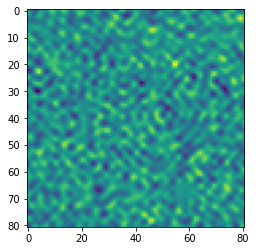

150


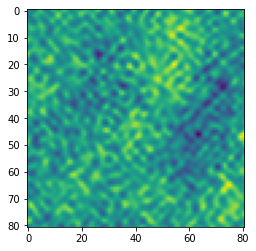

220


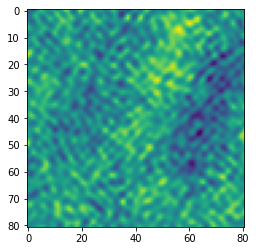

090


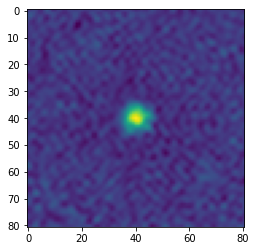

150


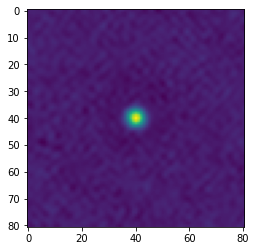

220


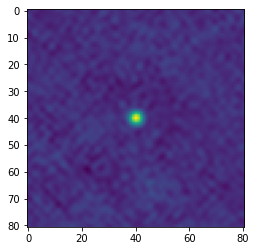

In [151]:
nysa.make_all_stacks()
vesta.make_all_stacks(pol='T')

In [137]:
print(vesta.map_dict['090'].at([0,0]))
print(vesta.map_dict['150'].at([0,0]))
print(vesta.map_dict['220'].at([0,0]))
print(jetta.map_dict['090'].at([0,0]))
print(jetta.map_dict['150'].at([0,0]))
print(jetta.map_dict['220'].at([0,0]))

322436.1
1491536.9
1552315.2
28040.188
31384.268
-53699.875


In [99]:
asteroid.map_dict['150'].wcs

tan:{cdelt:[-0.004167,0.004167],crval:[0,0],crpix:[41.00,41.00]}

In [131]:
obs = 'W99' #San Pedro

#table = QueryHorizons(time_start=58429.52446208872-10000, time_end=58429.52446208872+10000, observer_location='W99', step = '1d').queryObjects(['Ceres'])
table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects(['Vesta'])

In [132]:
orbits = OrbitInterpolator(table)

dict_keys(['4 Vesta (A807 FA)'])


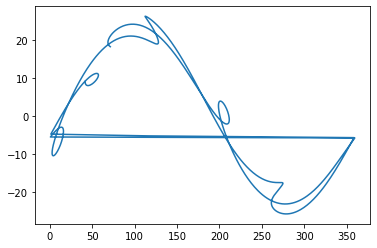

In [133]:
t_start = Time('2013-01-01T00:00:00', format='isot', scale='utc')
t_start = t_start.mjd

t_en = Time('2020-01-01T00:00:00', format='isot', scale='utc')
t_en = t_en.mjd
mjds = np.linspace(t_start, t_en, 1000)

ras, decs, delts = orbits.get_radec_dist(table['targetname'][0], mjds)

plt.plot(ras, decs)
plt.show()

In [134]:
flux_stack, fstack, kstack, flux_scale = tnoStacker(orbits,table['targetname'][0])


stacking on  4 Vesta (A807 FA)
In dir  s18_cmb_1536796800
dict_keys(['4 Vesta (A807 FA)'])
2267.3426964798473 16288.78558264324
2267.3426964798473 16288.78558264324
In dir  s18_cmb_1542240000
dict_keys(['4 Vesta (A807 FA)'])
2298.198358278296 14694.860761429662
2298.198358278296 14694.860761429662
In dir  s15_deep8_1437523200
dict_keys(['4 Vesta (A807 FA)'])
2960.3056453991776 244.5475363413443
2960.3056453991776 244.5475363413443
In dir  s15_deep9_1435449600
dict_keys(['4 Vesta (A807 FA)'])
2791.4024182636276 6490.136319598942
2791.4024182636276 6490.136319598942
In dir  s16_cmb_1476921600
dict_keys(['4 Vesta (A807 FA)'])
4935.346886075653 3476.7257945749207
4935.346886075653 3476.7257945749207
In dir  s15_deep9_1442707200
dict_keys(['4 Vesta (A807 FA)'])
2518.4510361455104 6326.878386803148
2518.4510361455104 6326.878386803148
In dir  s15_deep56_1451001600
dict_keys(['4 Vesta (A807 FA)'])
352.238268488396 2868.1819732657314
352.238268488396 2868.1819732657314
In dir  s19_cmb_15567552

KeyboardInterrupt: 

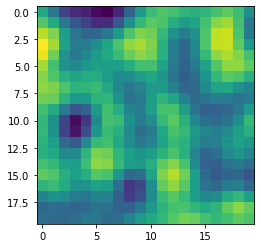

In [106]:
plt.imshow(flux_stack)
plt.savefig('/scratch/r/rbond/jorlo/actxminorplanets/asteroids/plots/{}_stamp.pdf'.format(str(table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')))
plt.show()

aster_dict = {'flux_stack':flux_stack, 'fstack':fstack, 'kstack':kstack, 'flux_scale':flux_scale}
with open('/scratch/r/rbond/jorlo/actxminorplanets/asteroids/pks/{}_stamp.pk'.format(str(table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')), 'wb') as f:
    pk.dump(aster_dict, f)

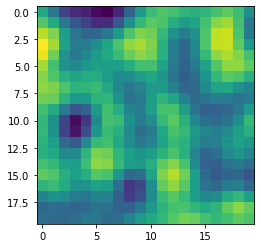

In [107]:
with open('/scratch/r/rbond/jorlo/actxminorplanets/asteroids/pks/{}_stamp.pk'.format(str(table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')), 'rb') as f:
    aster_dict = pk.load(f)
    kstack = aster_dict['kstack']
    fstack = aster_dict['fstack']
    
    flux_stack = fstack/kstack    
    plt.imshow(flux_stack)
    plt.show()

In [38]:
path = '/home/r/rbond/sigurdkn/scratch/actpol/planet9/20200801/maps/combined/'


table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects([502])

orbits =  OrbitInterpolator(table)

for  dirname in os.listdir(path=path):
    try:
        with h5py.File(path + dirname +"/info.hdf", "r") as hfile:
            #Find the (rough) mjd center of the map
            mjd_cent = hfile["mjd"][()]
            
        print(hfile.header())

    except:
        print('no info file in ', dirname)
        continue
    ra, dec, delta = orbits.get_radec_dist(table['targetname'][0], mjd_cent)
    print(ra, dec, delta)

0
no info file in  s18_cmb_1536796800
no info file in  s18_cmb_1542240000
no info file in  s15_deep8_1437523200
no info file in  s15_deep9_1435449600
no info file in  s16_cmb_1476921600
no info file in  s15_deep9_1442707200
no info file in  s15_deep56_1451001600
no info file in  s19_cmb_1556755200
no info file in  s13_deep2_1383350400
no info file in  s15_deep8_1447372800
no info file in  s13_deep5_1387497600
no info file in  s15_deep9_1439596800
no info file in  s15_deep9_1438300800
no info file in  s15_deep8_1439337600
no info file in  s19_cmb_1564272000
no info file in  s13_deep5_1381795200
no info file in  s15_boss_1438819200
no info file in  s15_deep9_1442966400
no info file in  s13_deep6_1380499200
no info file in  s15_deep8_1432857600
no info file in  s13_deep1_1378944000
no info file in  s16_cmb_1480032000
no info file in  s13_deep1_1383609600
no info file in  s13_deep6_1387497600
no info file in  s19_cmb_1572566400
no info file in  s16_cmb_1471737600
no info file in  s15_deep5

no info file in  s19_cmb_1561680000
no info file in  s18_cmb_1538870400
no info file in  s15_deep8_1438819200
no info file in  s13_deep1_1384905600
no info file in  s15_deep8_1434931200
no info file in  s15_boss_1443484800
no info file in  s15_deep9_1438041600
no info file in  s19_cmb_1564531200
no info file in  s16_cmb_1473033600
no info file in  s14_boss_1418342400
no info file in  s14_boss_1417305600
no info file in  s16_day_14h_n_1480809600
no info file in  s15_boss_1433894400
no info file in  s15_deep56_1449705600
no info file in  s17_cmb_1500249600
no info file in  s19_cmb_1553126400
no info file in  s18_cmb_1544313600
no info file in  s13_deep1_1387497600
no info file in  s13_deep1_1382054400
no info file in  s13_deep5_1383868800
no info file in  s15_deep56_1441929600
no info file in  s15_boss_1446595200
no info file in  s14_deep56_1415750400
no info file in  s17_cmb_1506211200
no info file in  s13_deep6_1386979200
no info file in  s16_day_02h_s_1471478400
no info file in  s15_d

no info file in  s15_deep56_1438819200
no info file in  s15_deep8_1433894400
no info file in  s16_day_02h_s_1480550400
no info file in  s15_deep56_1434931200
no info file in  s19_cmb_1568678400
no info file in  s14_boss_1419379200
no info file in  s13_deep5_1385683200
no info file in  s13_deep1_1385942400
no info file in  s15_boss_1433376000
no info file in  s15_deep8_1451520000
no info file in  s16_cmb_1473552000
no info file in  s17_cmb_1504137600
no info file in  s15_boss_1448409600
no info file in  s19_cmb_1563753600
no info file in  s18_cmb_1538092800
no info file in  s14_boss_1411344000
no info file in  s16_cmb_1482105600
no info file in  s14_deep56_1417046400
no info file in  s15_deep8_1438300800
no info file in  s13_deep2_1385424000
no info file in  s15_deep56_1437264000
no info file in  s15_boss_1447113600
no info file in  s15_deep8_1432339200
no info file in  s15_deep8_1449964800
no info file in  s19_cmb_1559606400
no info file in  s16_day_02h_s_1475625600
no info file in  s1

no info file in  s13_deep5_1382832000
no info file in  s18_cmb_1543536000
no info file in  s17_cmb_1506729600
no info file in  s15_deep56_1443744000
no info file in  s15_deep8_1449187200
no info file in  s13_deep1_1379203200
no info file in  s14_deep56_1419120000
no info file in  s16_day_14h_n_1474070400
no info file in  s15_boss_1447632000
no info file in  s16_day_14h_n_1480550400
no info file in  s13_deep2_1384128000
no info file in  s15_deep8_1446336000
no info file in  s19_cmb_1555200000
no info file in  s15_boss_1433635200
no info file in  s17_cmb_1516060800
no info file in  s16_day_14h_n_1464220800
no info file in  s15_deep9_1433894400
no info file in  s16_cmb_1475884800
no info file in  s18_cmb_1538611200
no info file in  s19_cmb_1554940800
no info file in  s15_deep56_1434672000
no info file in  s17_cmb_1495324800
no info file in  s19_cmb_1567123200
no info file in  s19_cmb_1557014400
no info file in  s15_deep8_1435708800
no info file in  s17_cmb_1513987200
no info file in  s14_

In [72]:
table['targetname'][0]

'Europa (502)'

0
s18_cmb_1541462400
58429.52446208872
ra, dec:  208.23085462296157 -4.415826753130108
19905.89872262212 3514.8003948121986


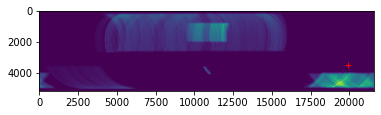

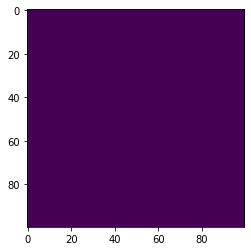

s18_cmb_1536537600
58372.61756241674
ra, dec:  184.9227856100031 5.911162180993855
21304.3828633996 4134.419730859624


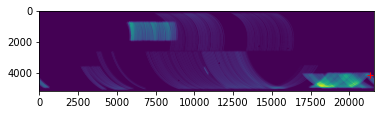

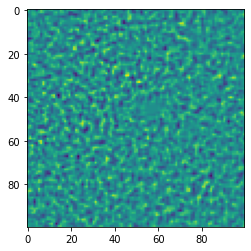

s18_cmb_1538352000
58393.569296172536
ra, dec:  193.46776000222982 1.929181018697992
20791.68439986601 3895.5008611218773


s18_cmb_1543795200
58456.50656068883
ra, dec:  219.22835862956742 -8.477559681136889
19246.048482225786 3271.0964191317967


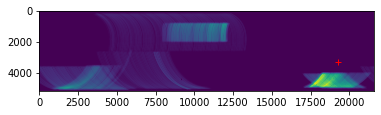

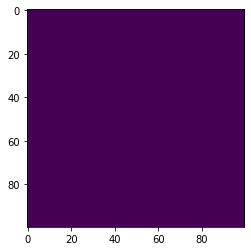

s18_cmb_1528243200
58276.8507168194
ra, dec:  147.69325835099139 23.226609407237095
1938.1544989406939 5173.346564434198


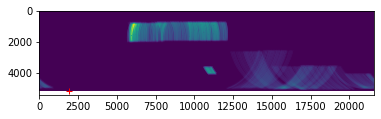

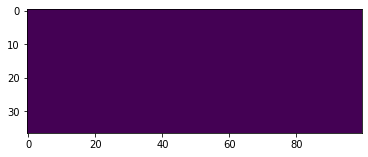

s18_cmb_1525651200
58246.46727990333
ra, dec:  138.02818270924314 27.417208395838124
2518.059037445577 5424.782503750254


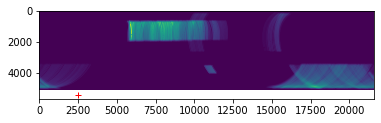

/tmp/ipykernel_46468/3499126242.py:36: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(fmap[int(y-50):int(y+50),int(x-50):int(x+50)])


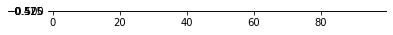

s18_cmb_1527465600
58267.50927254574
ra, dec:  144.49574693032235 24.61133586614251
2130.0051841808327 5256.430151968521


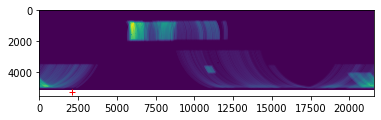

/tmp/ipykernel_46468/3499126242.py:36: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(fmap[int(y-50):int(y+50),int(x-50):int(x+50)])


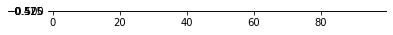

s18_cmb_1527206400
58264.98967472778
ra, dec:  143.66190260349546 24.97095596661909
2180.035843790445 5278.007357997116


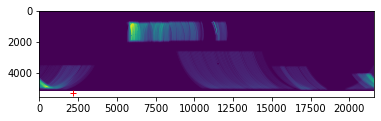

/tmp/ipykernel_46468/3499126242.py:36: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(fmap[int(y-50):int(y+50),int(x-50):int(x+50)])


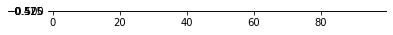

s18_cmb_1544313600
58462.03530593746
ra, dec:  221.44766154441157 -9.213978588284869
19112.89030733514 3226.911284702919


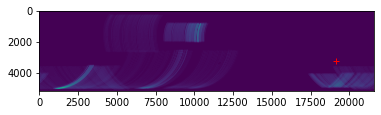

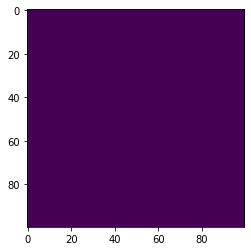

s18_cmb_1527984000
58273.24477721383
ra, dec:  146.44026652662848 23.770653149855995
2013.3340084024676 5205.9891889913315


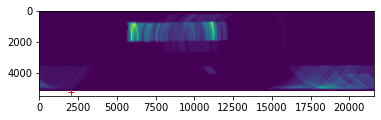

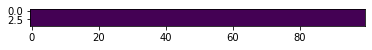

s18_cmb_1540166400
58414.73956544741
ra, dec:  202.1554774423525 -1.9098374924643804
20270.42135345866 3665.1597504521396


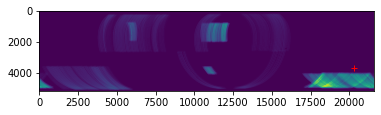

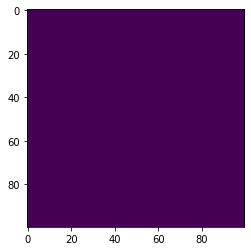

s18_cmb_1536796800
58375.41006159657
ra, dec:  186.05805485619464 5.374127670406174
21236.266708628114 4102.197660224364


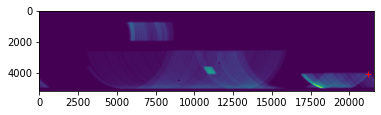

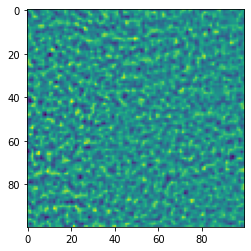

s18_cmb_1537056000
58378.489483829275
ra, dec:  187.31134271005678 4.7835932157528775
21161.069437396385 4066.765592945167


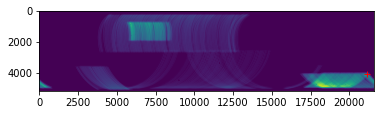

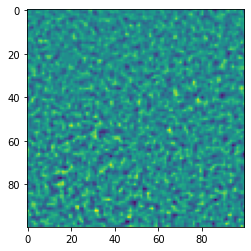

s18_cmb_1543536000
58453.863463292975
ra, dec:  218.16166001708862 -8.113271725907094
19310.050398974512 3292.9536964455842


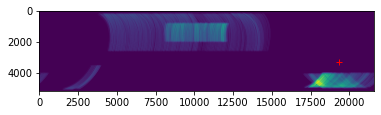

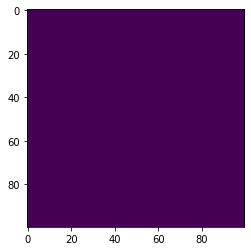

s18_cmb_1539388800
58405.494640098885
ra, dec:  198.35791933180008 -0.2643157690813206
20498.274840091803 3763.8910538551213


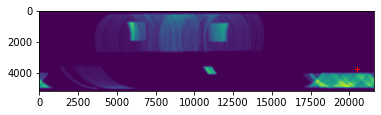

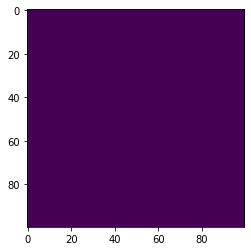

s18_cmb_1527724800
58270.54465643587
ra, dec:  145.51708916154269 24.17023345428045
2068.724650307613 5229.964007256798


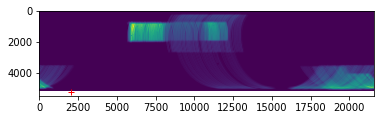

/tmp/ipykernel_46468/3499126242.py:36: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(fmap[int(y-50):int(y+50),int(x-50):int(x+50)])


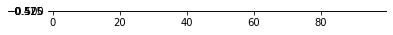

s18_cmb_1543276800
58450.39318566434
ra, dec:  216.75641430992448 -7.62308555001406
19394.36514140436 3322.3648669991653


In [ ]:
path = '/global/cscratch1/sd/jorlo/three_day_maps/'

table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects(['Ceres'])

orbits =  OrbitInterpolator(table)

for  dirname in os.listdir(path=path):
    print(dirname)
    try:
        with h5py.File(path + dirname +"/info.hdf", "r") as hfile:
            #Find the (rough) mjd center of the map
            mjd_cent = hfile["mjd"][()]

    except:
        print('no info file in ', dirname)
        continue
    print(mjd_cent)
    ra, dec, delta = orbits.get_radec_dist(table['targetname'][0], mjd_cent)
    print('ra, dec: ', ra, dec)
    
    hdu = fits.open(path + dirname + '/kmap.fits')
    w = wcs.WCS(hdu[0].header)
    
    c = SkyCoord(ra, dec, unit="deg")
    x, y = w.world_to_pixel(c)
    print(x,y)
    kmap = enmap.read_map(path + dirname + '/kmap.fits')
    try:
        fmap = enmap.read_map(path + dirname + '/frhs.fits')
    except: continue
    plt.imshow(kmap)
    plt.plot(x,y, color='red', marker='+')
    plt.show()
    plt.close()

    plt.imshow(fmap[int(y-50):int(y+50),int(x-50):int(x+50)])
    plt.show()
    plt.close()

In [52]:
path = '/home/r/rbond/sigurdkn/scratch/actpol/planet9/20200801/maps/combined/'


with h5py.File(path + 's18_cmb_1536796800' +"/info.hdf", "r") as hfile:
    #Find the (rough) mjd center of the map
    mjd_cent = hfile["mjd"][()]
    print(hfile['mjd'][()])



58375.41006159657
